# **ME C231A, EE C220B, Experiential Advanced Control I**
# **Final Exam Fall 2023**
# University of California, Berkeley

Remember
1. **DO NOT SHARE THIS COLAB NOTEBOOK WITH ANYONE**. Sharing this notebook without authorization of Charlott Vallon and Fionna Kopp will be considered as an act of academic dishonesty.
2. The submission process will be the same as your homework.
3. Submit the PDF of the write-up and the .ipynb file of your solution to Gradescope before the timer ends.
4. Multiple submissions are allowed as long as it is before the timer ends.
5. **Your  submission of your solutions will act as a confirmation that you have not discussed this exam with anyone during the exam period. We have different tools to identify cheating, and we will not tolerate any exception.**


Instructions
1. Make a copy of this Colab notebook
2. Write your answers
3. Submit two files on Gradescope: (1) The .ipynb file, and (2) A PDF containing your solutions. You can make the PDF either by directly printing this notebook or by making screenshots. However, your PDF must contain all code you wrote as well as the results of the unit tests and other deliverables.



In [ ]:
# Please run this cell only if you are using Google Colab.

# install required dependencies
# import sys
# IN_COLAB = 'google.colab' in sys.modules
# if IN_COLAB:

!pip install -q pyomo
!apt-get install -y -qq glpk-utils
!apt-get install -y -qq coinor-cbc
!wget -N -q "https://github.com/thomasfork/ipopt_linux/raw/main/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
!pip install polytope

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.8 MB/s eta 0:00:00
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 120882 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected pac

------

Helper functions:

In [ ]:
import polytope as pt
import numpy as np
import matplotlib.pyplot as plt
import scipy
# DO NOT MODIFY THIS CELL
# Helper Functions:

def minkowski_sum(X, Y):

    # Minkowski sum between two polytopes based on
    # vertex enumeration. So, it's not fast for the
    # high dimensional polytopes with lots of vertices.
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        # assuming vertices are in (N x d) shape. N # of vertices, d dimension
        V1 = X

    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
    return pt.qhull(np.asarray(V_sum))

def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([])):
        if not B.any():
            return pt.Polytope(Xset.A @ A, Xset.b)
        else:
            tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)

def Oinf(Xset, A, Wset=pt.Polytope()):
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = pt.reduce(precursor(Omega, A, Wset=Wset).intersect(Omega))
        else:
            Omegap = pt.reduce(precursor(Omega, A).intersect(Omega))
    return Omegap


------

We define the parameters here

In [ ]:
# DO NOT MODIFY THIS CELL
# Scene parameters
l_car   = 4.5  # m
d_stop = 100

# CFTOC parameters
nz      = 2       # number of states
nu      = 1       # number of inputs
Ts      = 1       # s
N       = 3       # Horizon
v_max   = 32      # m/s
g       = 9.81    # m/s^2

# Initial condition
zbar0 = np.array([0,20]).T # Initial condition

# Cost matrices
Q = np.array([[0,0],
              [0,1]])
R = 1

Hint: how to extract solver's termination_condition in Pyomo

In [ ]:
import pyomo.environ as pyo
from pyomo.opt import SolverStatus, TerminationCondition

# Example of extracting the termination_condition of the solver:
example_model = pyo.ConcreteModel()
example_model.x = pyo.Var()
example_model.obj = pyo.Objective(expr=example_model.x)
example_model.const = pyo.Constraint(expr = example_model.x >= 0)
example_results = pyo.SolverFactory('cbc').solve(example_model)

example_termination_condition = example_results.solver.termination_condition

print(f'The solver termination condition: {example_termination_condition}')
print(f'Is termination_condition == optimal? {example_termination_condition==TerminationCondition.optimal}') # Terminating optimally means the problem is feasible!

The solver termination condition: optimal
Is termination_condition == optimal? True


# <font color='red'>DELIVERABLES:</font>

<font color='red'>D1:</font> Write a **function** `cftoc`, which solves the CFTOC (3) using *Pyomo*, with function declaration line

` def cftoc(zbar0, d_stop, N, P, Af = np.nan, bf=np.nan): return zOpt, uOpt, is_optimal`

 where the input` zbar0` is the initial state of the vehicle and `d0` is the initial distance to the intersection. P is the terminal cost matrix. Af and bf represent the terminal constraint set where $X_f = \{x\in \mathbb{R}^2|A_f x \leq b_f\}$. The function should have three outputs. zOpt and uOpt are optimizers each representing $(z_0^*,...,z_N^*)$ and $(u_0^*,...,u_{N-1}^*)$, respectively. Lastly, is_optimal is a binary variable representing the optimality of the solver's termination condition.

**Hints:**


*   refer to the example provided in this exam starter code to see how to extract the TerminationCondition of a solver)
*   refer to HW 6 to see how terminal constraint can be implemented in Pyomo given $A_f$ and $b_f$
*   refer to the Midterm Coding Exam for hints on writing the CFTOC in Pyomo (CFTOC is not exactly the same as the one in the midterm)



**Submit the result of the provided unit test**

In [ ]:
import pyomo.environ as pyo
from pyomo.opt import SolverStatus, TerminationCondition

def cftoc(zbar0, d_stop, N, P, Af = np.nan, bf=np.nan):

  # Write your code here:

  model = pyo.ConcreteModel()
  model.N = N
  model.nz = nz
  model.nu = nu
  if not np.isnan(Af).any(): model.nf = np.size(Af, 0)

  # Length of finite optimization problem:
  model.tidz = pyo.Set(initialize=range(0, model.N+1), ordered=True)
  model.tidu = pyo.Set(initialize=range(0, model.N), ordered=True)
  model.zidz = pyo.Set(initialize=range(0, model.nz), ordered=True)
  model.uidz = pyo.Set(initialize=range(0, model.nu), ordered=True)
  if not np.isnan(Af).any(): model.nfidz = pyo.Set(initialize= range(model.nf), ordered=True)

  # These are 2d arrays:
  model.P = P
  model.R = np.array([[R]])
  model.Q = Q
  model.Af = Af
  model.bf = bf

  # Create state and input variables trajectory:
  model.z = pyo.Var(model.zidz, model.tidz)
  model.u = pyo.Var(model.uidz, model.tidu)
  model.zbar0 = zbar0

  # Objective:
  def objective_rule(model):
    costZ = 0.0
    costU = 0.0
    costTerminal = 0.0
    for t in model.tidz:
      for i in model.zidz:
        for j in model.zidz:
          if t < model.N:
            costZ += (model.z[i, t] - model.zbar0[i]) * model.Q[i, j] * (model.z[i, t] - model.zbar0[i])
    for t in model.tidz:
      for i in model.uidz:
        for j in model.uidz:
          if t < model.N:
            costU += model.u[i, t] * model.R[i, j] * model.u[j, t]
    for i in model.zidz:
      for j in model.zidz:
        costTerminal += (model.z[i, model.N] - model.zbar0[i]) * model.P[i, j] * (model.z[i, model.N] - model.zbar0[i])
    return costZ + costU + costTerminal

  model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)

  # Constraints:
  # Initial condition
  model.constraint1 = pyo.Constraint(model.zidz, rule=lambda model, i: model.z[i, 0] == zbar0[i])

  # State dynamics
  model.constraint2 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[0, t+1] == model.z[0, t] + Ts * model.z[1, t]
                                    if t < N else pyo.Constraint.Skip)
  model.constraint3 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[1, t+1] == model.z[1, t] + Ts * model.u[0, t]
                                    if t < N else pyo.Constraint.Skip)

  # State constraints
  model.constraint4 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[0, t] >= 0)
  model.constraint5 = pyo.Constraint(model.tidz, rule = lambda model, t: model.z[0, t] <= d_stop - l_car/2)
  model.constraint6 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[1, t] >= 0)
  model.constraint7 = pyo.Constraint(model.tidz, rule=lambda model, t: model.z[1, t] <= v_max) # Speed limit

  # Input constraints
  model.constraint8 = pyo.Constraint(model.tidu, rule=lambda model, t: model.u[0,t] >= -g*0.5)
  model.constraint9 = pyo.Constraint(model.tidu, rule=lambda model, t: model.u[0,t] <= g*0.5)

  # Final constraints
  if not np.isnan(Af).any():
    def final_const_rule(model, i):
      return sum(model.Af[i, j] * model.z[j, model.N] for j in model.zidz) <= model.bf[i]
    model.constraint10 = pyo.Constraint(model.nfidz, rule=final_const_rule)

  # Now we can solve:
  results = pyo.SolverFactory('ipopt').solve(model)

  zOpt = np.asarray([[model.z[i,t]() for i in model.zidz] for t in model.tidz]).T
  uOpt = np.asarray([model.u[:,t]() for t in model.tidu])
  JOpt = model.cost()

  return zOpt, uOpt, results.solver.termination_condition=='optimal'

The function ` def sim_mpc(zbar0,d_stop,N,Af,bf,P): return zOpt ` defined below executes a closed-loop MPC simulation for $M = 100$ steps. This function will **plot the closed-loop trajectories as well as open-loop predictions** if the MPC is recursively feasible. **If not recursively feasible, it will not plot anything and print out a Pyomo infeasibility warning.** Note that inside this function, we are calling `cftoc(zbar0, d_stop, N, P, Af = np.nan, bf=np.nan)` as defined above. The output of the function returns the optimizers $(z_0^*,...,z_N^*)$


In [ ]:
# DO NOT MODIFY THIS CELL
def sim_mpc(z0, d_stop, N, Af, bf, P):
  # Simulation time
  M = 100

  ####### Initialize #######
  zOpt = np.zeros((nz, M+1))
  uOpt = np.zeros((nu, M))
  zOpt[:, 0] = z0.reshape(nz, )
  feas = np.zeros((M, ), dtype=bool)
  zN = np.zeros((nz,1))
  infeas_flag = False
  ##########################

  fig = plt.figure(figsize=(9, 6))

  # MPC Closed-loop simulation
  for time in range(M):
    z, a, feas[time] = cftoc(zOpt[:, time], d_stop, N, P, Af, bf)

    if not feas[time]:
      zOpt = []
      uOpt = []
      infeas_flag = True
      break
    # Save closed loop trajectory
    # Note that the second column of x represents the optimal closed loop state
    zOpt[:, time+1] = z[:,1]
    uOpt[:, time] = a[0]

  # Plot Open Loop
  line1 = plt.plot(z[0,:], z[1,:], 'b--')

  #Print/plot results
  if infeas_flag:
    print(feas) # You may see a plot with some openloop trajectories even when the MPC is not recursively feasible. Ignore this figure.
  else:
    print(feas)
    # Plot Closed Loop and Openloop trajectories
    line2 = plt.plot(zOpt[0, :], zOpt[1, :], 'go-')
    plt.legend([line1[0], line2[0]], ['Open-loop', 'Closed-loop']);
    plt.axvline(x=100, ymin=-100, ymax=100, c = 'r')
    plt.xlabel('d (m)')
    plt.ylabel('v (m/s)')
    plt.ylim([0,50])
    plt.axis('equal')

  return zOpt

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


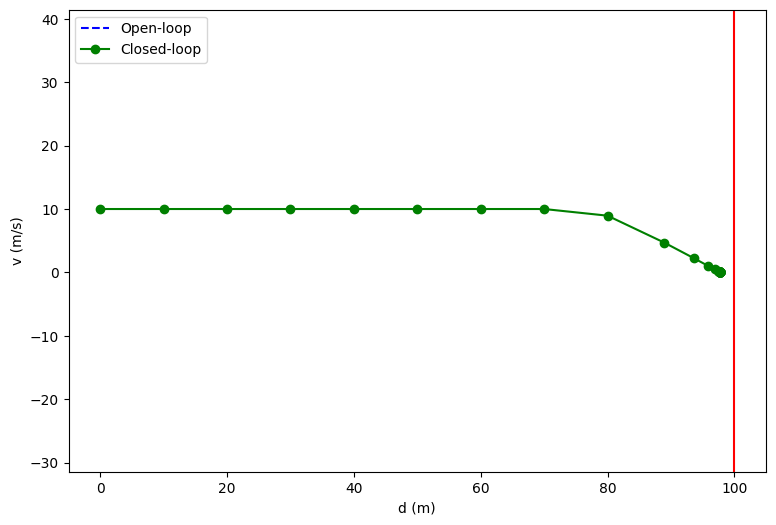

In [ ]:
# Unit test (Submit the results of this unit test in your write-up)
_ = sim_mpc(np.array([0,10]), d_stop, N, np.nan, np.nan, P=Q)

------

<font color='red'>D2:</font> Use $\bar{z}_{0}=[0,20]^{\top}$ and $d_{stop}=100$ m. Call the `sim_mpc()` function from (D1) with the given inputs `zbar0`=$\bar{z}_0$, `d_stop`=$d_{stop}$, $P = Q$, $N=3$ to determine recursive feasibility and plot closed-loop trajectories with open-loop predictions.. Do not impose any terminal constraints here (i.e. $A_f=b_f=np.nan$).

* Submit the results of the sim\_mpc() function for the given conditions, including a plot of open-loop predictions and closed-loop trajectories.
* Is the MPC that you designed recursively feasible using the given settings and initial condition during the simulation time $M=100$? Explain why or why not (Only stating that the MPC is feasible for n-steps or no longer feasible after k-steps is not an acceptable answer. Please explain why this happens).
* In case the MPC is not recursively feasible for a particular initial condition, could increasing $N$ make it recursively feasible from the same initial condition? Explain the pros and cons of this approach.  


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


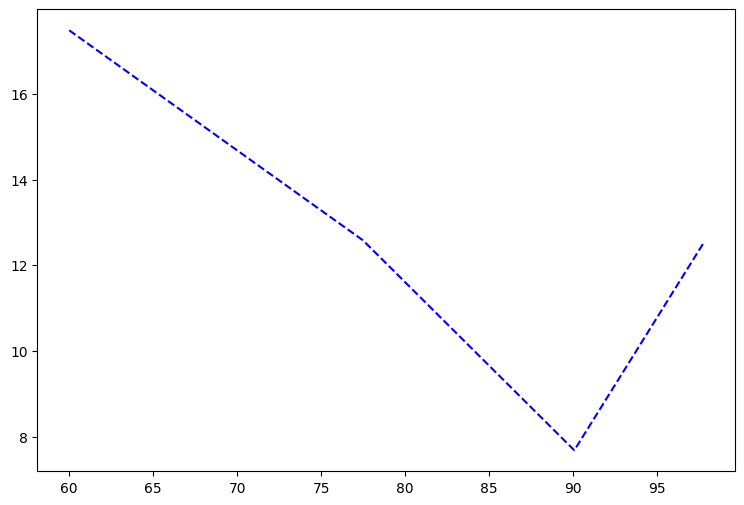

In [ ]:
# Write your code here:
# Note that majority of the points for D2 will be based on your explanation.

_ = sim_mpc(np.array([0,20]), d_stop, N, np.nan, np.nan, P=Q)

------

<font color='red'>D3:</font> Use $\bar{z}_{0}=[0,20]^{\top}$ and $d_{stop}=100$ m. Here we want to impose the terminal set $X_f=\{[d_{stop}-l_{car}/2,0]^\top\}$. Design $A_f$ and $b_f$ accordingly (**Hint:** you need to convert this equality constraint into inequality **constraints**) and call the `sim_mpc()` function from (D2) with the given inputs `zbar0`=$\bar{z}_0$, `d_stop`=$d_{stop}$, $P = Q$, $N=3$, and $A_f$ and $b_f$ you designed.
* Submit the results of the sim\_mpc() function for the given conditions, including a plot of open-loop predictions and closed-loop trajectories.
* Is the MPC that you designed recursively feasible using the given settings and initial condition during the simulation time $M=100$? Explain why or why not (Only stating that the MPC is feasible for n-steps or no longer feasible after k-steps is not an acceptable answer. Please explain why this happens).
* Compute and plot the initial feasible set $X_0$ of the MPC along with $X$, which is the state constraint set.
* Is the MPC that you designed recursively feasible for all initial states in $X_0$ using the given settings and initial conditions for $M=100$? Explain why or why not (Stating that the MPC is feasible for n-steps or no longer feasible after k-steps is not an acceptable answer).

The constraint sets $X$ and $U$ are defined for you. Also, an epsilon box around $X_f=\{[d_{stop}-l_{car}/2,0]^\top\}$ is defined for computation of $X_0$ in (D3).

In [ ]:
# DO NOT MODIFY THIS CELL:

# State Dynamics
A = np.array([[1, Ts],
               [0, 1]])
B = np.array([[0],
              [Ts]])

# Define state and input bounds
xU = d_stop-l_car/2
xL = 0
vU = v_max
vL = 0
uU = g/2

# Constraint sets represented as polyhedra
X = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[xU],
                          [vU],
                          [xL],
                          [vL]]))

U = pt.Polytope(np.array([1, -1]).reshape(2,1),
                np.array([uU, uU]).reshape(2,1))

# Since the Polytope package cannot handle non full-dimensional
# polytopes, we need to define an epsilon box around Xf in
# order to run the code:
eps = 0.001
eps_box = pt.box2poly([[-eps+d_stop-l_car/2, eps+d_stop-l_car/2], [0, eps]])

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


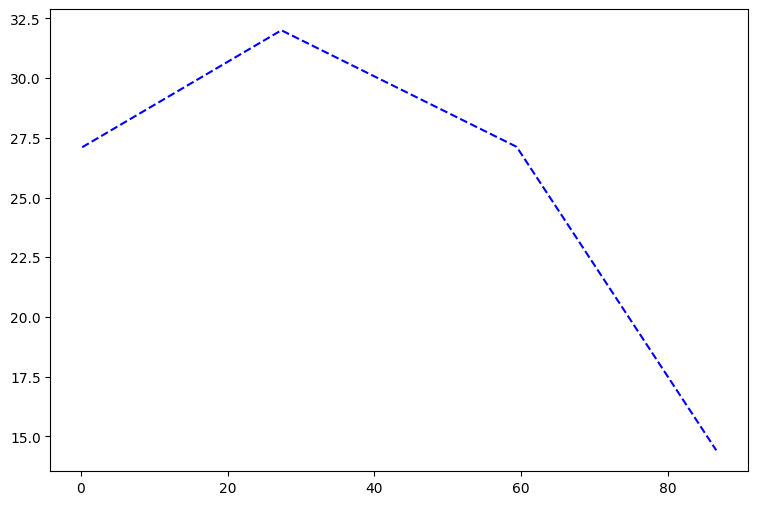

In [ ]:
# Write your code here:
# D3 - (i)

Af = np.array([[1, 0],
               [0, 1],
               [-1, 0],
               [0, -1]])

bf = np.array([xU, 0, -xU, 0])

_ = sim_mpc(np.array([0, 20]), d_stop, N, Af, bf, P=Q)

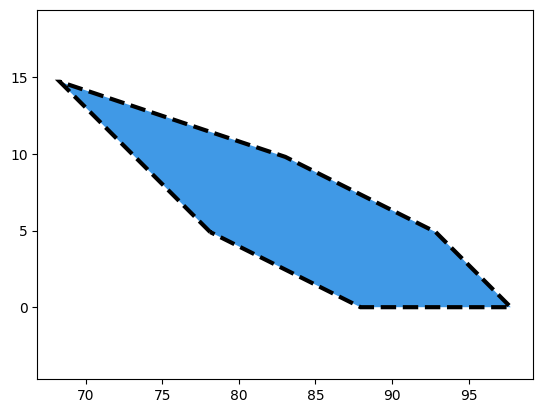

In [ ]:
# D3 - (iii)

C = {}

fig, ax = plt.subplots()
PreS = precursor(eps_box, A, U, B)
for k in range(N):
  C[k]= PreS.intersect(X)
  PreS = precursor(C[k], A, U, B)

X0_1 = C[N-1]
C[N-1].plot(ax)
ax.autoscale_view()
ax.axis('equal')
plt.show()

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


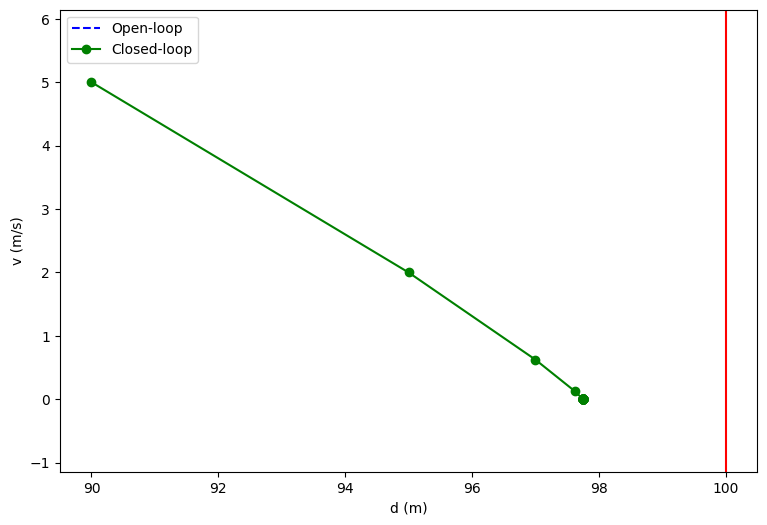

In [ ]:
# D3 - (iv)

_ = sim_mpc(np.array([90, 5]), d_stop, N, Af, bf, P=Q)

------

<font color='red'>D4:</font> Use $\bar{z}_{0}=[0,20]^{\top}$ and $d_{stop}=100$ m. Call the `sim_mpc()` function from (D1) with the given inputs `zbar0`=$\bar{z}_0$, `d_stop`=$d_{stop}$, $P = P_{∞}$, $N=3$.

Now set $X_f$ to be the maximal invariant set $O_\infty$ for the closed loop system $x(k+1) = (A+BF_\infty)x(k)$ subject to
the given constraints. Here $F_\infty$ is the infinite time LQR controller for the system $x(k+1) = Ax(k)+Bu(k)$ with weights $Q$ and $R$ defined previously, such that $u(k)=F_{\infty} x(k)$. Choose the terminal cost $P$ to be $P_{\infty}$ which is the infinite time cost associated with the controller $u(k)=F_{\infty}x(k)$. Write your code in the following format that formulates and solves the MPC problem. (Note: your code will be largely similar to your previous one, with the exception that you are now using different terminal constraints)

* Submit the results of the sim\_mpc() function for the given conditions, including a plot of open-loop predictions and closed-loop trajectories.
* Compute and plot the initial feasible set $X_0$ (N-step controllable set to $X_f$) along with $X$, which is the state constraint set.
* Is the MPC that you designed recursively feasible for all initial states in $X_0$ using the given settings and initial conditions for $M=100$? Explain why or why not (Stating that the MPC is feasible for n-steps or no longer feasible after k-steps is not an acceptable answer).


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


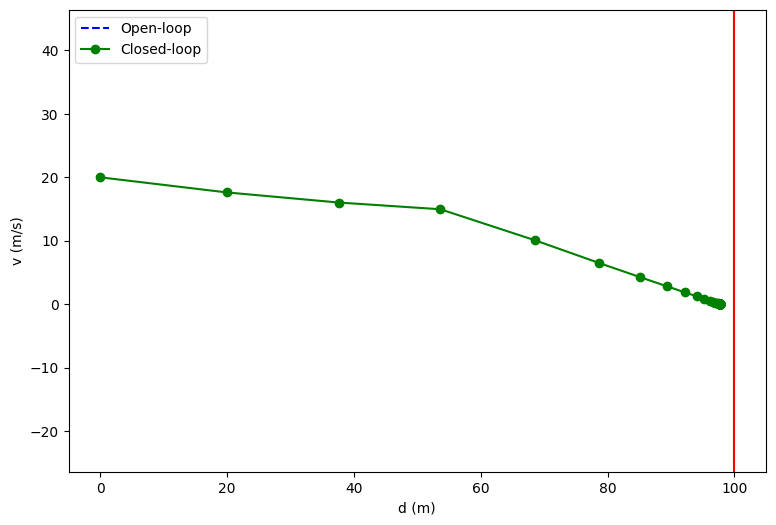

In [ ]:
# Write your code here:
# D4 - (i)

import scipy.linalg

def dlqr(A, B, Q, R):
    # solve Discrete Algebraic Riccatti equation
    P = scipy.linalg.solve_discrete_are(A, B, Q, R)

    # compute the LQR gain
    K = -scipy.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)

    # stability check
    eigVals, eigVecs = scipy.linalg.eig(A + B @ K)
    return K, P, eigVals

F_inf, P_inf, eigvals = dlqr(A, B, Q, R)
A_cl = A + B @ F_inf
S = X.intersect(pt.Polytope(U.A@F_inf, U.b))
O_inf = Oinf(S, A_cl)
Af = O_inf.A
bf = O_inf.b

_ = sim_mpc(np.array([0, 20]), d_stop, N, Af, bf, P=P_inf)

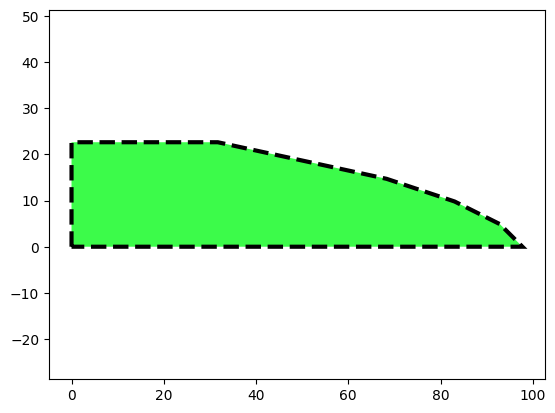

In [ ]:
# D4 - (ii)

C = {}

fig, ax = plt.subplots()
PreS = precursor(O_inf, A, U, B)
for k in range(N):
  C[k]= PreS.intersect(X)
  PreS = precursor(C[k], A, U, B)

X0_2 = C[N-1]
C[N-1].plot(ax)
ax.autoscale_view()
ax.axis('equal')
plt.show()

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


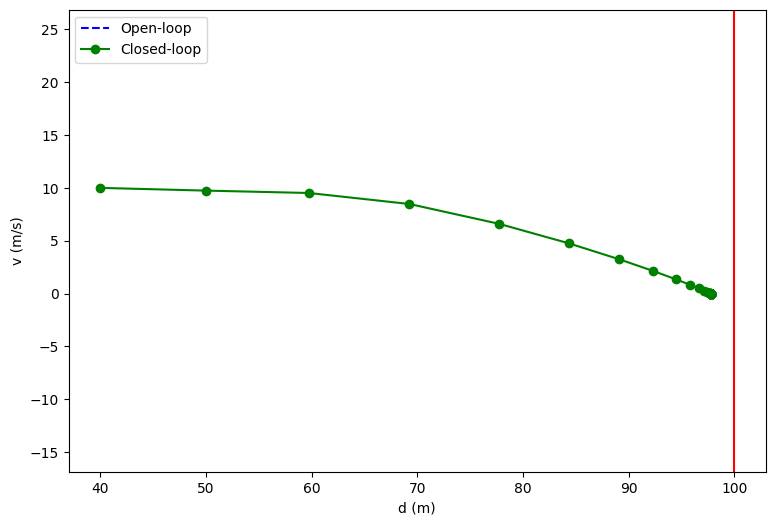

In [ ]:
# D4 - (iii)

_ = sim_mpc(np.array([40, 10]), d_stop, N, Af, bf, P=Q)

------

<font color='red'>D5:</font> Plot $X_0^1$, $X_0^2$,   $X$, and $C_{\infty}$ on the same figure, where $X_0^1$ is the initial feasible set from (D3), $X_0^2$ is the initial feasible set from (D4), $X$ is the state constraint set, and $C_{\infty}$ is the maximal control invariant set for the system $x(k+1) = Ax(k)+Bu(k)$ subject to the given constraints.

* Plot $X_0^1$, $X_0^2$, $X$, and $C_{\infty}$ on the same figure. Comment on how they compare in sizes and make statements on which design approach is "better" and why.`
* Let $X_{D2}$ be the initial feasible set of the MPC designed in D2. Is $X_{D2}$ an invariant set? If not, can you compute the $O_{\infty}$ set for the closed-loop system $x(k+1) = Ax(k)+Bu(k)$ where $u(k)$ is the MPC controller designed in (D2) subject to the given constraints? If easy, please compute, if not easy explain why.
* Using the same dynamic model, horizon length, sampling time, state/input constraints, can you design an MPC controller with $X_0=C_{\infty}$? If yes, explain how you would approach designing such an MPC controller and what the associated difficulties are.

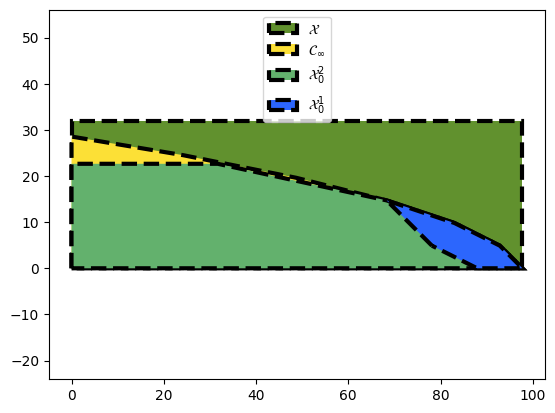

In [ ]:
# Write your code here:

# D5 - (i)

def Cinf(Xset, A, Uset, B, Wset=pt.Polytope()):
  Omega = Xset
  k = 0
  Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
  while not Omegap == Omega:
    k += 1
    Omega = Omegap
    if not pt.is_empty(Wset):
      Omegap = precursor(Omega, A, Uset, B, Wset=Wset).intersect(Omega)
    else:
      Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
  return Omegap

Cinfset = Cinf(X, A, U, B)

fig, ax = plt.subplots()
X.plot(ax)
Cinfset.plot(ax)
X0_2.plot(ax)
X0_1.plot(ax)

ax.autoscale_view()
ax.axis('equal')
plt.legend(['$\mathcal{X}$','$\mathcal{C}_\infty$','$\mathcal{X}_0^2$','$\mathcal{X}_0^1$'])
plt.show()

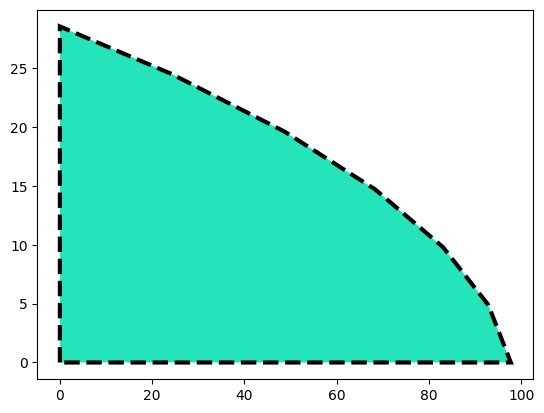

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


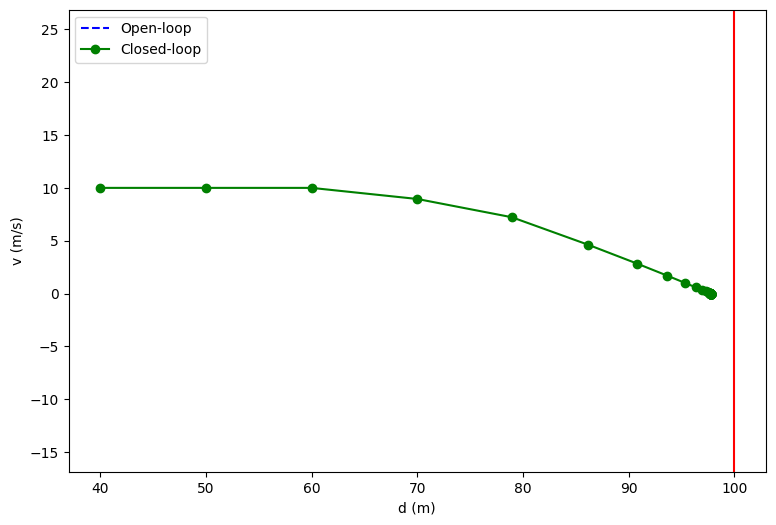

In [ ]:
# D5 - (iii)

fig, ax = plt.subplots()
Cinfset.plot(ax)
ax.autoscale_view()
plt.show()
Af = Cinfset.A
bf = Cinfset.b
_ = sim_mpc(np.array([40, 10]), d_stop, N, Af, bf, P=Q)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


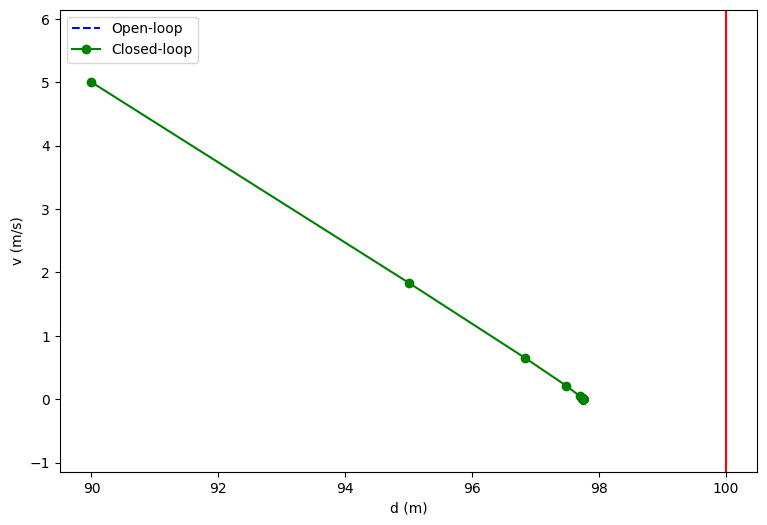

In [ ]:
_ = sim_mpc(np.array([90, 5]), d_stop, N, Af, bf, P=Q)